In [0]:
# Restart runtime using 'Runtime' -> 'Restart runtime...'
%tensorflow_version 2.x
import tensorflow as tf
print(tf.__version__)



/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:529: FutureWarning: Passing (type, 1) or 

TensorFlow 2.x selected.
1.13.1


In [0]:
!pip install tensorflow==1.13.1

In [0]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
!ln -s "/content/gdrive/My Drive" "/content/mydrive"

ln: failed to create symbolic link '/content/mydrive': File exists


In [0]:
import sys
import os
import numpy as np
import tensorflow as tf
import keras 
import matplotlib.pyplot as plt
import time

from keras import optimizers, callbacks, regularizers
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator
from keras.models import *
from keras.callbacks import CSVLogger
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Input, Dropout, Flatten, Dense, Activation, Conv2D, MaxPooling2D
from tensorflow.train import AdamOptimizer
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.python.tools import freeze_graph, optimize_for_inference_lib
from sklearn.metrics import classification_report, confusion_matrix


Using TensorFlow backend.


In [0]:
start = time.time()

DEV = False
argvs = sys.argv
argc = len(argvs)

if argc > 1 and (argvs[1] == "--development" or argvs[1] == "-d"):
  DEV = True

if DEV:
  epochs = 2
else:
  epochs = 500

In [0]:
"""
Parameters
"""
img_width, img_height = 188, 188
batch_size = 50
samples_per_epoch = 1000
validation_steps = 512
classes_num = 2
lr = 0.001

In [0]:
train_data_path = 'drive/My Drive/data/train_paretto'
val_data_path = 'drive/My Drive/data/val_paretto'
test_data_path = 'drive/My Drive/data/test_paretto'

In [0]:
train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    shear_range=0.2,
    zoom_range=0.2,
    rotation_range=180,
    horizontal_flip=True,
    fill_mode="nearest")

val_datagen = ImageDataGenerator(rescale=1. / 255)

train_generator = train_datagen.flow_from_directory(
    train_data_path,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical')

validation_generator = val_datagen.flow_from_directory(
    val_data_path,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False)

Found 2048 images belonging to 2 classes.
Found 512 images belonging to 2 classes.


In [0]:
model = Sequential()

# convo 1
model.add(Conv2D(20, (5,5),padding='valid',activation='relu', input_shape=(img_width, img_height, 3)))
model.add(MaxPooling2D(pool_size=(4, 4)))
# model.add(Dropout(0.1))

# convo 2
model.add(Conv2D(50, (5,5),padding='valid'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(6, 6)))
# model.add(Dropout(0.1))


model.add(Flatten())
model.add(Dense(100))
model.add(Activation('relu'))
# model.add(Dropout(0.1))

model.add(Dense(classes_num, activation='softmax', kernel_regularizer=regularizers.l1(lr)))
# model.add(Dense(classes_num, activation='softmax'))


model.summary()



Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 184, 184, 20)      1520      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 46, 46, 20)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 42, 42, 50)        25050     
_________________________________________________________________
activation (Activation)      (None, 42, 42, 50)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 50)          0         
_________________________________________________________________
flatten (Flatten)            (None, 2450)              0         
_________________________________________________________________
dens

In [0]:
tpu_model = tf.contrib.tpu.keras_to_tpu_model(
    model,
    strategy=tf.contrib.tpu.TPUDistributionStrategy(
        tf.contrib.cluster_resolver.TPUClusterResolver(tpu='grpc://' + os.environ['COLAB_TPU_ADDR'])
    )
)


tpu_model.compile(
    loss='categorical_crossentropy',
    optimizer=tf.train.AdamOptimizer(learning_rate=lr),  
    metrics=['accuracy']
)


INFO:tensorflow:Querying Tensorflow master (grpc://10.16.250.74:8470) for TPU system metadata.
INFO:tensorflow:Found TPU system:
INFO:tensorflow:*** Num TPU Cores: 8
INFO:tensorflow:*** Num TPU Workers: 1
INFO:tensorflow:*** Num TPU Cores Per Worker: 8
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, -1, 9558962334534955753)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 17179869184, 14108147039463151655)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 17179869184, 9763163184617435033)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 17179869184, 17742111993606794531)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 17179869184, 5660051470079135753)
INFO:tensorflow:*** Available Device: _DeviceAttributes(

In [0]:
es = EarlyStopping(monitor='val_loss', mode='min', patience=100, restore_best_weights=True)
csv_logger = CSVLogger('log.csv', append=True, separator=';')

In [0]:

"""
Lets Training 
"""


history = tpu_model.fit_generator(
    train_generator,
    steps_per_epoch=2048 //batch_size,
    epochs=epochs,
    # callbacks=[csv_logger] ,
    callbacks=[es, csv_logger],
    validation_data=validation_generator,
    validation_steps=512//batch_size
)


Epoch 1/500
INFO:tensorflow:New input shapes; (re-)compiling: mode=train (# of cores 8), [TensorSpec(shape=(6,), dtype=tf.int32, name='core_id0'), TensorSpec(shape=(6, 188, 188, 3), dtype=tf.float32, name='conv2d_input_10'), TensorSpec(shape=(6, 2), dtype=tf.float32, name='dense_1_target_10')]
INFO:tensorflow:Overriding default placeholder.
INFO:tensorflow:Remapping placeholder for conv2d_input
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Use tf.cast instead.
INFO:tensorflow:Started compiling
INFO:tensorflow:Finished compiling. Time elapsed: 7.468085765838623 secs
INFO:tensorflow:Setting weights on TPU model.
40/41 [============================>.] - ETA: 1s - loss: 0.3410 - acc: 0.8828INFO:tensorflow:New input shapes; (re-)compiling: mode=eval (# of cores 8), [TensorSpec(shape=(6,), dtype=tf.int32, name='core_id_10'), TensorSpec(shape=(6, 188, 188, 3), dtype=tf.float32, name='conv2d_input_10'), TensorSpec(shape=(6, 2), dtype=tf.float32, name='dense_1_targe

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])


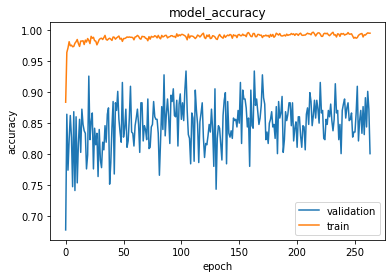

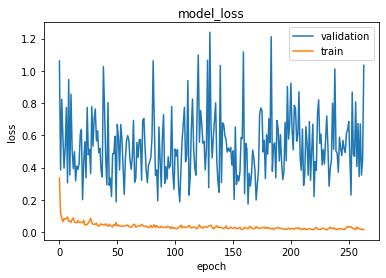

In [0]:
print(history.history.keys())

# accuracy
# plt.plot(history.history['categorical_crossentropy'])
plt.plot(history.history['val_acc'])
plt.plot(history.history['acc'])
plt.title('model_accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['validation', 'train'], loc='lower right')
plt.locator_params(axis='x',integer=True)
plt.show()
# loss
# plt.plot(history.history['categorical_crossentropy'])
plt.plot(history.history['val_loss'])
plt.plot(history.history['loss'])
plt.title('model_loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['validation', 'train'], loc='upper right')
plt.locator_params(axis='x',integer=True)
plt.show()

In [0]:
cpu_model = tpu_model.sync_to_cpu()

In [0]:
test_datagen = ImageDataGenerator(rescale=1. / 255)
test_generator = test_datagen.flow_from_directory(
    test_data_path,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False)
#Confution Matrix and Classification Report
Y_pred = cpu_model.predict_generator(test_generator, 640 // batch_size)
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
print(confusion_matrix(test_generator.classes, y_pred))
print('Classification Report')
target_names = ['melanoma', 'nevus']
print(classification_report(test_generator.classes, y_pred, target_names=target_names, digits=5))

Found 640 images belonging to 2 classes.
Confusion Matrix
[[285  35]
 [  9 311]]
Classification Report
              precision    recall  f1-score   support

    melanoma    0.96939   0.89062   0.92834       320
       nevus    0.89884   0.97188   0.93393       320

    accuracy                        0.93125       640
   macro avg    0.93412   0.93125   0.93114       640
weighted avg    0.93412   0.93125   0.93114       640



In [0]:
# json_config = tpu_model.to_json()
tpu_model.save('cnn04.h5')
tpu_model.save_weights('weights_cnn04.h5')


In [0]:
#Confution Matrix and Classification Report
Y_pred = cpu_model.predict_generator(validation_generator, validation_steps // batch_size)
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
print(confusion_matrix(validation_generator.classes, y_pred))
print('Classification Report')
target_names = ['melanoma', 'nevus']
print(classification_report(validation_generator.classes, y_pred, target_names=target_names, digits=5))

Confusion Matrix
[[228  28]
 [  5 251]]
Classification Report
              precision    recall  f1-score   support

    melanoma    0.97854   0.89062   0.93252       256
       nevus    0.89964   0.98047   0.93832       256

    accuracy                        0.93555       512
   macro avg    0.93909   0.93555   0.93542       512
weighted avg    0.93909   0.93555   0.93542       512

